In [1]:
import os
import time
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [2]:
DATA_PATH = '/media/xiaolong/9bbdf31a-3238-4691-845c-7f9126769abe/Dataset/fruits-360'

In [3]:
files_training = glob(os.path.join(DATA_PATH,'Training', '*/*.jpg'))
files_testing = glob(os.path.join(DATA_PATH, 'Test', '*/*.jpg'))
num_images = len(files_training)
print('Number of images in Training file:', num_images)
print(len(files_testing))

Number of images in Training file: 41322
13877


In [4]:
min_images = 1000
im_cnt = []
class_names = []
print('{:20s}'.format('class'), end='')
print('Count')
print('-' * 24)
for folder in os.listdir(os.path.join(DATA_PATH, 'Training')):
    folder_num = len(os.listdir(os.path.join(DATA_PATH,'Training',folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < min_images):
        min_images = folder_num
        folder_name = folder
        
num_classes = len(class_names)
print("\nMinumum imgages per category:", min_images, 'Category:', folder)    
print('Average number of Images per Category: {:.0f}'.format(np.array(im_cnt).mean()))
print('Total number of classes: {}'.format(num_classes))

class               Count
------------------------
Grapefruit Pink      490
Cherry Wax Yellow    492
Apple Granny Smith   492
Limes                490
Rambutan             492
Strawberry Wedge     738
Clementine           490
Cantaloupe 2         492
Pomegranate          492
Grape White 2        490
Pear Williams        490
Cocos                490
Apple Red 1          492
Avocado ripe         491
Cherry Wax Black     492
Passion Fruit        490
Maracuja             490
Physalis with Husk   492
Huckleberry          490
Strawberry           492
Raspberry            490
Cactus fruit         490
Plum                 447
Carambula            490
Kaki                 490
Grape Pink           492
Dates                490
Tamarillo            490
Grape White          490
Pear                 492
Tomato Cherry Red    492
Tomato 4             479
Lemon                492
Apple Golden 2       492
Apple Red Delicious  490
Pitahaya Red         490
Cherry Rainier       738
Guava                490

In [5]:
tensor_transform = transforms.Compose([transforms.ToTensor()])
all_data = ImageFolder(os.path.join(DATA_PATH, 'Training'), tensor_transform)
data_loader = torch.utils.data.DataLoader(all_data, batch_size=512, shuffle=True)

In [6]:
pop_mean = []
pop_std = []

for i, data in enumerate(data_loader, 0):
    numpy_image = data[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

pop_mean = np.array(pop_mean).mean(axis=0)
pop_std = np.array(pop_std).mean(axis=0)


In [7]:
print(pop_mean)
print(pop_std)

[0.7037323  0.58449835 0.49839947]
[0.28723374 0.3510937  0.38105354]


In [8]:
np.random.seed(123)
shuffle = np.random.permutation(num_images)
print(shuffle, len(shuffle))

[21131 20574 28905 ... 17730 28030 15725] 41322


In [9]:
split_val = int(num_images * 0.2)
print('Total number of images:', num_images)
print('Number of valid images after split:',len(shuffle[:split_val]))
print('Number of train images after split:',len(shuffle[split_val:]))

Total number of images: 41322
Number of valid images after split: 8264
Number of train images after split: 33058


In [10]:
from torch.utils.data import Dataset
class FruitTrainDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[split_val:]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

class FruitValidDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[:split_val]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y
    
class FruitTestDataset(Dataset):
    def __init__(self, path, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.data = np.array(glob(os.path.join(path, '*/*.jpg')))
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'Test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ])
}

train_dataset = FruitTrainDataset(files_training, shuffle, split_val, class_names, data_transforms['train'])
valid_dataset = FruitValidDataset(files_training, shuffle, split_val, class_names, data_transforms['valid'])
test_dataset = FruitTestDataset(os.path.join(DATA_PATH, 'Test'), class_names, transform=data_transforms['Test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [12]:
dataloaders = {'train': train_loader,
              'valid': valid_loader,
              'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}

dataset_sizes

{'train': 33058, 'valid': 8264, 'Test': 13877}

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = pop_std * inp + pop_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

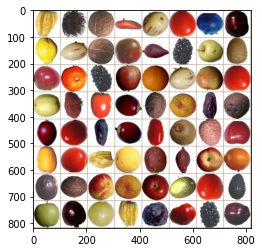

['Physalis with Husk', 'Rambutan', 'Walnut', 'Banana Red', 'Pepino', 'Tomato Cherry Red', 'Huckleberry', 'Cherry 2', 'Quince', 'Pepino', 'Walnut', 'Tomato Maroon', 'Salak', 'Mulberry', 'Apple Golden 2', 'Kiwi', 'Cherry Rainier', 'Clementine', 'Mulberry', 'Apple Red 3', 'Orange', 'Pepino', 'Apple Red 2', 'Tomato Cherry Red', 'Apple Golden 2', 'Strawberry Wedge', 'Kaki', 'Tamarillo', 'Cocos', 'Mandarine', 'Dates', 'Cocos', 'Tamarillo', 'Tomato 4', 'Dates', 'Tamarillo', 'Tomato 2', 'Kiwi', 'Lychee', 'Cherry 2', 'Kumquats', 'Tomato Cherry Red', 'Physalis with Husk', 'Cantaloupe 1', 'Grape Pink', 'Salak', 'Nectarine', 'Tangelo', 'Passion Fruit', 'Cocos', 'Apple Red Yellow', 'Mandarine', 'Apple Braeburn', 'Melon Piel de Sapo', 'Tomato Cherry Red', 'Avocado ripe', 'Apple Granny Smith', 'Cherry 1', 'Grape White 2', 'Physalis with Husk', 'Dates', 'Tomato 3', 'Mulberry', 'Apple Red Delicious']


In [14]:
inputs, classes = next(iter(train_loader))
out = make_grid(inputs)

fruits = ['' for x in range(len(classes))]
for i in range(len(classes)):
    fruits[i] = class_names[classes[i].item()]
    
imshow(out)
print(fruits)

In [15]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 10 * 10, 250)
        self.fc2 = nn.Linear(250, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = x.view(-1, 64 * 10 * 10)
        x = F.dropout(F.relu(self.fc1(x)), training=self.training, p=0.4)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1) 

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
from torchsummary import summary
model = Net(num_classes)
model.to(device)
summary(model, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]           1,216
       BatchNorm2d-2           [-1, 16, 96, 96]              32
         MaxPool2d-3           [-1, 16, 48, 48]               0
            Conv2d-4           [-1, 32, 46, 46]           4,640
       BatchNorm2d-5           [-1, 32, 46, 46]              64
         MaxPool2d-6           [-1, 32, 23, 23]               0
            Conv2d-7           [-1, 64, 21, 21]          18,496
       BatchNorm2d-8           [-1, 64, 21, 21]             128
         MaxPool2d-9           [-1, 64, 10, 10]               0
           Linear-10                  [-1, 250]       1,600,250
           Linear-11                   [-1, 81]          20,331
Total params: 1,645,157
Trainable params: 1,645,157
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forw

/home/xiaolong/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.01, momentum=0.9)
from torch.optim.lr_scheduler import *
scheduler=StepLR(optimizer,step_size=3)

In [19]:
def train(model,device, train_loader, epoch):
    model.train()
    for data in tqdm(train_loader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
    print ('Train Epoch: {}\t Loss: {:.6f}'.format(epoch, loss.item()))

In [20]:
def valid(model, device, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for data in tqdm(valid_loader):          
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            valid_loss += criterion(y_hat, y).item() # sum up batch loss
            pred = y_hat.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(y.view_as(pred)).sum().item()
    valid_loss /= len(valid_loader.dataset)
    print('\nValid set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, len(valid_dataset),
        100. * correct / len(valid_dataset)))

In [21]:
for epoch in range(1, 10):
    train(model=model, device=device, train_loader=train_loader, epoch=epoch)
    valid(model=model, device=device, valid_loader=valid_loader)

  2%|▏         | 3/130 [00:00<00:04, 27.22it/s]

Train Epoch: 1	 Loss: 0.351694


  1%|          | 3/517 [00:00<00:18, 27.27it/s]


Valid set: Average loss: 0.0020, Accuracy: 7917/8264 (96%)



  2%|▏         | 3/130 [00:00<00:04, 27.39it/s]

Train Epoch: 2	 Loss: 0.319196


  1%|          | 3/517 [00:00<00:18, 27.32it/s]


Valid set: Average loss: 0.0018, Accuracy: 7950/8264 (96%)



  2%|▏         | 3/130 [00:00<00:04, 27.51it/s]

Train Epoch: 3	 Loss: 0.188639


  1%|          | 3/517 [00:00<00:18, 27.87it/s]


Valid set: Average loss: 0.0005, Accuracy: 8159/8264 (99%)



  2%|▏         | 3/130 [00:00<00:04, 27.30it/s]

Train Epoch: 4	 Loss: 0.080472


  1%|          | 3/517 [00:00<00:18, 27.62it/s]


Valid set: Average loss: 0.0006, Accuracy: 8148/8264 (99%)



  2%|▏         | 3/130 [00:00<00:04, 26.75it/s]

Train Epoch: 5	 Loss: 0.107731


  1%|          | 3/517 [00:00<00:18, 27.27it/s]


Valid set: Average loss: 0.0004, Accuracy: 8176/8264 (99%)



  2%|▏         | 3/130 [00:00<00:04, 27.32it/s]

Train Epoch: 6	 Loss: 0.077317


  1%|          | 3/517 [00:00<00:18, 27.86it/s]


Valid set: Average loss: 0.0002, Accuracy: 8199/8264 (99%)



  2%|▏         | 3/130 [00:00<00:04, 27.35it/s]

Train Epoch: 7	 Loss: 0.043464


  1%|          | 3/517 [00:00<00:18, 27.78it/s]


Valid set: Average loss: 0.0003, Accuracy: 8195/8264 (99%)



  2%|▏         | 3/130 [00:00<00:04, 27.42it/s]

Train Epoch: 8	 Loss: 0.041066


  1%|          | 3/517 [00:00<00:18, 27.45it/s]


Valid set: Average loss: 0.0002, Accuracy: 8216/8264 (99%)



  2%|▏         | 3/130 [00:00<00:04, 27.75it/s]

Train Epoch: 9	 Loss: 0.030560


100%|██████████| 130/130 [00:04<00:00, 27.51it/s]


Valid set: Average loss: 0.0001, Accuracy: 8219/8264 (99%)

